# Classify using start=0 mid = 1 end = 2

In [1]:
import sys
import pandas as pd
import numpy as np

## 1. Read dataset

In [2]:
dirname = '../../datasets/marked_start_mid_end/'
suffix = '.csv'

def read_from_file( file_name, rand_num):
    
    try:
        full_file_name = file_name + str(rand_num) + "_kinect"

        file_at_path = dirname + full_file_name + suffix

        data = pd.read_csv(file_at_path)
        
        return data, full_file_name
    
    except IOError as e:
        print(e)
        return None,None

## 2. Read files

### 2.1 The A series (A1-A159)

In [3]:
raw_data, full_file_name = read_from_file("A", 1)

#print(full_file_name)
print(raw_data.shape)

for i in range(2,160):
    input_data, full_file_name = read_from_file("A", i)
    
    if(full_file_name is None):
        continue
    else:
        #print(full_file_name)
        raw_data = raw_data.append(input_data, ignore_index = True)

print(raw_data.shape)

(229, 41)
[Errno 2] No such file or directory: '../../datasets/marked_start_mid_end/A60_kinect.csv'
[Errno 2] No such file or directory: '../../datasets/marked_start_mid_end/A107_kinect.csv'
(32387, 41)


### 2.2 The B series (B1-B22)

In [4]:
for i in range(1,23):
    input_data, full_file_name = read_from_file("B", i)
    
    if(full_file_name is None):
        continue
    else:
        #print(full_file_name)
        raw_data = raw_data.append(input_data, ignore_index = True)

print(raw_data.shape)

(37782, 41)


In [5]:
start_0, mid_1, end_2 = np.bincount(raw_data['status'])
print(
    'Frames:\n    Total: {}\n    Before: {} ({:.2f}% of total)\n    During: {} ({:.2f}% of total)\n    After: {} ({:.2f}% of total)\n'
    .format(
      len(raw_data), 
      start_0,
      start_0 / len(raw_data),
      mid_1,
      mid_1 / len(raw_data),
      end_2,
      end_2 / len(raw_data)
    )
  )

Frames:
    Total: 37782
    Before: 7814 (0.21% of total)
    During: 22931 (0.61% of total)
    After: 7037 (0.19% of total)



In [6]:
cleaned_data = raw_data.copy()
cleaned_data.pop( 'FrameNo')

0          0
1          1
2          2
3          3
4          4
        ... 
37777    235
37778    236
37779    237
37780    238
37781    239
Name: FrameNo, Length: 37782, dtype: int64

In [7]:
# Use a utility from sklearn to split and shuffle our dataset.

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(cleaned_data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('status'))
val_labels = np.array(val_data.pop('status'))
test_labels = np.array(test_data.pop('status'))

train_features = np.array(train_data)
val_features = np.array(val_data)
test_features = np.array(test_data)

### Normalization
Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (24180,)
Validation labels shape: (6045,)
Test labels shape: (7557,)
Training features shape: (24180, 39)
Validation features shape: (6045, 39)
Test features shape: (7557, 39)


In [9]:
import tensorflow as tf
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [11]:
def make_model(metrics=METRICS, optimizer='Adam',loss = 'categorical_crossentropy'):
    model = keras.Sequential([
        keras.layers.Dense(units=16, activation='relu',input_dim=train_features.shape[-1]),
        keras.layers.Dense(32, activation='relu' ),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    #keras.losses.BinaryCrossentropy()
    return model

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1,patience=10,mode='max',restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


# Checkpoint the initial weights

In [14]:
import os
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [15]:
history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
12/12 [==============================] - 2s 69ms/step - loss: 0.0000e+00 - tp: 429.3077 - fp: 111.5385 - tn: 2819.3077 - fn: 10757.3846 - accuracy: 0.2131 - precision: 0.7691 - recall: 0.0408 - auc: 0.3438 - prc: 0.7367 - val_loss: 0.0000e+00 - val_tp: 334.0000 - val_fp: 11.0000 - val_tn: 1185.0000 - val_fn: 4515.0000 - val_accuracy: 0.2005 - val_precision: 0.9681 - val_recall: 0.0689 - val_auc: 0.5551 - val_prc: 0.8594
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 862.9231 - fp: 13.7692 - tn: 2911.3846 - fn: 10329.4615 - accuracy: 0.2112 - precision: 0.9834 - recall: 0.0760 - auc: 0.6020 - prc: 0.8715 - val_loss: 0.0000e+00 - val_tp: 410.0000 - val_fp: 0.0000e+00 - val_tn: 1196.0000 - val_fn: 4439.0000 - val_accuracy: 0.2076 - val_precision: 1.0000 - val_recall: 0.0846 - val_auc: 0.6897 - val_prc: 0.9125
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 934.1538 - fp: 0.0000e+00 - tn: 2928.

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [17]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  1339.0
fp :  3.0
tn :  1601.0
fn :  4614.0
accuracy :  0.32671695947647095
precision :  0.997764527797699
recall :  0.2249286025762558
auc :  0.7708603739738464
prc :  0.9361129999160767



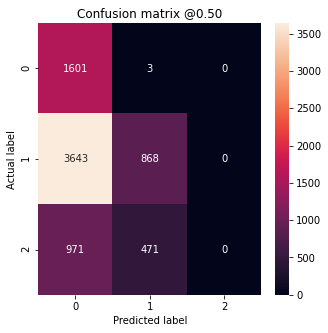

In [18]:
results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

#plot_cm(train_labels, train_predictions_baseline)

# Class weights

In [19]:
weight_for_0 = (1 / start_0)*(len(raw_data))/3.0 
weight_for_1 = (1 / mid_1)*(len(raw_data))/3.0
weight_for_2 = (1 / end_2)*(len(raw_data))/3.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.61
Weight for class 1: 0.55
Weight for class 2: 1.79


In [20]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
12/12 [==============================] - 2s 68ms/step - loss: 0.0000e+00 - tp: 1841.4615 - fp: 155.9231 - tn: 4365.4615 - fn: 15311.6923 - accuracy: 0.2569 - precision: 0.9232 - recall: 0.1167 - auc: 0.5538 - prc: 0.8303 - val_loss: 0.0000e+00 - val_tp: 401.0000 - val_fp: 14.0000 - val_tn: 1182.0000 - val_fn: 4448.0000 - val_accuracy: 0.2046 - val_precision: 0.9663 - val_recall: 0.0827 - val_auc: 0.5307 - val_prc: 0.8510
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - tp: 977.0000 - fp: 22.0000 - tn: 2935.9231 - fn: 10182.6154 - accuracy: 0.2192 - precision: 0.9763 - recall: 0.0858 - auc: 0.5770 - prc: 0.8595 - val_loss: 0.0000e+00 - val_tp: 461.0000 - val_fp: 11.0000 - val_tn: 1185.0000 - val_fn: 4388.0000 - val_accuracy: 0.2119 - val_precision: 0.9767 - val_recall: 0.0951 - val_auc: 0.6799 - val_prc

In [21]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  1661.0
fp :  7.0
tn :  1597.0
fn :  4292.0
accuracy :  0.36720919609069824
precision :  0.9958033561706543
recall :  0.27901896834373474
auc :  0.7764900922775269
prc :  0.9379057884216309



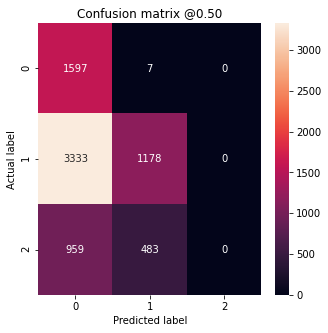

In [22]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [23]:
# over sample

In [24]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
train_features_sm, train_labels_sm = oversample.fit_resample(train_features, train_labels)
print(train_features_sm.shape,train_labels_sm.shape)

(44220, 39) (44220,)


In [25]:
os_model = make_model()
os_model.load_weights(initial_weights)
os_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = os_model.fit(
    train_features_sm,
    train_labels_sm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
22/22 [==============================] - 2s 37ms/step - loss: 0.0000e+00 - tp: 3222.9565 - fp: 228.3478 - tn: 9539.2174 - fn: 18980.7391 - accuracy: 0.3422 - precision: 0.9300 - recall: 0.1509 - auc: 0.5211 - prc: 0.7598 - val_loss: 0.0000e+00 - val_tp: 462.0000 - val_fp: 11.0000 - val_tn: 1185.0000 - val_fn: 4387.0000 - val_accuracy: 0.2119 - val_precision: 0.9767 - val_recall: 0.0953 - val_auc: 0.6691 - val_prc: 0.9048
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - tp: 2947.9130 - fp: 10.8261 - tn: 8108.6957 - fn: 13346.8261 - accuracy: 0.3450 - precision: 0.9951 - recall: 0.1776 - auc: 0.6650 - prc: 0.8373 - val_loss: 0.0000e+00 - val_tp: 891.0000 - val_fp: 0.0000e+00 - val_tn: 1196.0000 - val_fn: 3958.0000 - val_accuracy: 0.2859 - val_precision: 1.0000 - val_recall: 0.1837 - val_auc: 0.7443 - val_prc: 0.9330
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - tp: 4065.4783 - fp: 11.9130 - tn: 8142.

In [27]:
train_predictions_os = os_model.predict(train_features_sm, batch_size=BATCH_SIZE)
test_predictions_os = os_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  1745.0
fp :  7.0
tn :  1597.0
fn :  4208.0
accuracy :  0.3783247172832489
precision :  0.996004581451416
recall :  0.29312950372695923
auc :  0.7738773822784424
prc :  0.9372656345367432



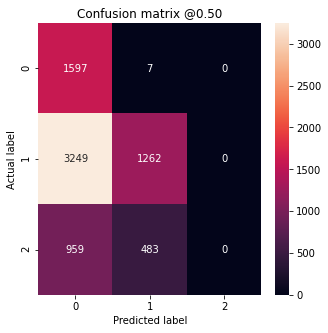

In [28]:
results = os_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(os_model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_os)

#plot_cm(train_labels, train_predictions_baseline)